### Introduction

This assignment will get you familiar with the Gymnasium (previously OpenAI Gym) environment and estimation via sampling trajectories.


In [4]:
import gymnasium as gym
import numpy as np

We will be playing on the Cartpole environment. As the title suggests, the task in this environment is to balance a pole on top of a cart. The official description of the environment from the Gymnasium website (https://gymnasium.farama.org/environments/classic_control/cart_pole/) is:

> This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

More information can be found on the that wiki page.

The environment is loaded as follows:

In [17]:
env = gym.make('CartPole-v1')
env.reset() #must reset the environment before interacting with it


(array([-0.02637273,  0.00786041, -0.03403224, -0.01535948], dtype=float32),
 {})

Here is the policy that you will be using (which just acts randomly with a uniform distribution). 

In [18]:
def policy_unif(s):
  a = env.action_space.sample()
  return a

In [19]:
env.step(env.action_space.sample())

(array([-0.02621552,  0.20345348, -0.03433944, -0.31858274], dtype=float32),
 1.0,
 False,
 False,
 {})

 You can interact with the environment with the env.step() function, as follows:

In [11]:
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(observation)
print(reward)
print(terminated)
print(info)

[ 0.03569882  0.55785906 -0.1506548  -1.0316151 ]
1.0
False
{}


In [21]:
def rbf_random_fourier_features(state, action, feature_dim, length_scale=1.0):
    np.random.seed(0)
    state_array = np.array(state[0], dtype=np.float32).reshape(-1)
    action_array = np.array([float(action)])
    state_action = np.concatenate((state_array, action_array))
    dim = state_action.shape[0]
    
    # Handle even/odd feature dimensions
    if feature_dim % 2 == 0:
        d_cos = d_sin = feature_dim // 2
    else:
        d_cos = (feature_dim + 1) // 2
        d_sin = (feature_dim - 1) // 2
    
    omega = np.random.normal(scale=1.0/length_scale, size=(dim, d_cos))
    bias = np.random.uniform(0, 2 * np.pi, size=d_cos)
    z = state_action @ omega + bias
    cos_features = np.cos(z)
    sin_features = np.sin(z[:d_sin]) if d_sin > 0 else np.array([])
    feature = np.sqrt(1.0 / feature_dim) * np.concatenate([cos_features, sin_features])
    return feature

In [60]:
# Generate a state-action pair
# import random
# random.seed(0)
state = env.reset()
action = env.action_space.sample()

# Calculate the feature
feature_dim = 5 # You can adjust the feature dimension as needed
length_scale = 1.0  # You can adjust the length scale as needed
feature = rbf_random_fourier_features(state, action, feature_dim, length_scale)

print("State:", state)
print("Action:", action)
print("Feature:", feature)

State: (array([ 0.02442347,  0.03630089,  0.03739835, -0.03865002], dtype=float32), {})
Action: 1
Feature: [ 0.32081474  0.21318276 -0.44342887  0.31157327 -0.39313243]


### Question 1

Write a method called collect_trajectory(policy) which collects one trajectory for an episode in the Cartpole environment. Your method should take as input the policy and output a list of the form (s0,a0,r0,s1,a1,r1,...,sT,aT,rT), where T is the length of the episode.

In [5]:
#Q1 solution
def collect_trajectory(policy):
  s0 = env.reset()
  traj_list = [s0]
  while True:
    a0 = policy(s0)
    traj_list.append(a0)
    s1, r0, done, _, _ = env.step(a0)
    traj_list.append(r0)
    traj_list.append(s1)
    s0 = s1
    if done:
      break
  return traj_list[:-1] #removing the terminal state


### Question 2

Write a method called compute_return, which takes as input one trajectory of the form given by collect_trajectory in Q1 and a discount factor, and calculates the random return of the trajectory, i.e., r0 + γ r1 + γ^2 r2 + ... + γ^T rT.

In [6]:
#Q2 solution
def compute_return(traj,gamma):
  if traj==[]:
    return 0
  else:
    return traj[2]+gamma*compute_return(traj[3:],gamma)

### Question 3

Collect 150 trajectories starting from the initial states given by env.reset() and compute the random return of each trajectory, using the given policy and $\gamma=0.99$.

1.   Plot a histogram of these returns.
2.   Estimate the mean of these returns, and give your result in the form of $X \pm Y$, where $X$ is the estimated mean and $Y$ is twice the standard error of your mean estimate, which corresponds to a 95% confidence interval.

Remark: The mean is also an estimate of the value function of $\pi$ for the initial state, often referred to as a "Monte-Carlo" estimation.

The estimated return is  19.97 +/- 1.47


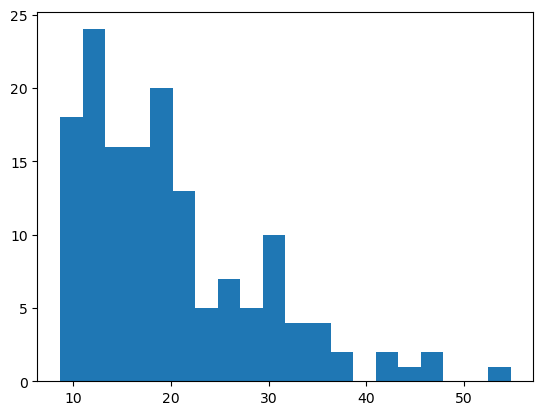

In [7]:
#Q3 solution:
import matplotlib.pyplot as plt
import numpy as np

#100 returns
returns=[]
for i in range(150):
  returns.append(compute_return(collect_trajectory(policy_unif),0.99))

#plotting
plt.hist(returns, bins = 20)

#estimated return
value = np.mean(returns)
from scipy import stats
stderr = 2 * stats.sem(returns)
print('The estimated return is ', round(value, 2), '+/-', round(stderr, 2))